# 2 Image Processing Pipeline

In [120]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
from helperfunctions import *

## 2.1 Load Camera Calibration and Initialize Global Variables

In [121]:
with open("Project_Output/cam_calib_res.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]
Test_images = glob.glob("test_images/*.jpg")
showimages=False
saveimages=False

## 2.2 Distortion Correction

In [122]:
# Get a test image to undistort

for fname in Test_images:

    # Read in image
    #img = cv2.imread(fname)
    example_distorted_test_image = cv2.imread(fname)
    example_distorted_test_image_RGB = cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB)
    example_undistorted_test_image = cv2.undistort(example_distorted_test_image_RGB,mtx,dist)

    # Display the distorted test alongside its undistorted counterpart

    if showimages:
        fig=plt.figure(figsize=(20,10))
        plt.subplot(121),plt.imshow(example_distorted_test_image_RGB)
        plt.title('Distorted', fontsize=30)
        plt.subplot(122),plt.imshow(example_undistorted_test_image)
        plt.title('Undistorted', fontsize=30)
        fig.suptitle(fname, fontsize=16)
    if saveimages:
        mpimg.imsave("Undistorted_"+fname,example_undistorted_test_image)


## 2.3 Color Transforms & Gradient Thresholding

In [123]:
def generate_binary_image_v1(image, sobel_thresholds=(30, 140), color_thresholds=(150, 255)):
    image = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    sxbinary_l= abs_sobel_thresh(l_channel, orient='x', sobel_kernel=3, thresh=sobel_thresholds)
    sxbinary_s= abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, thresh=sobel_thresholds)   
      
    # Thresholding on the color channels
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresholds[0]) & (s_channel <= color_thresholds[1])] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 60) & (l_channel <= 230)] = 1
    
    combined = np.zeros_like(s_channel)
    combined[((s_binary == 1) & (l_binary == 1)) | (sxbinary_s == 1)|(sxbinary_l==1)] = 1     

    return combined
def generate_binary_image_v2(image, sobel_thresholds=(30, 140), color_thresholds=(150, 255)):
    image = np.copy(image)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    sxbinary_l= abs_sobel_thresh(l_channel, orient='x', sobel_kernel=3, thresh=sobel_thresholds)
    sxbinary_s= abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, thresh=sobel_thresholds)   
      
    # Thresholding on the color channels
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresholds[0]) & (s_channel <= color_thresholds[1])] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 230) & (l_channel <= 255)] = 1
    
    combined = np.zeros_like(s_channel)
    combined[(s_binary == 1) | (sxbinary_s == 1)|(sxbinary_l==1)] = 1     

    return combined
def generate_binary_image_v3(image, sobel_thresholds=(30, 140), color_thresholds=(150, 255)):
    # Convert to YCrCb color space
    img = np.copy(image)
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    mask_YCrCb = cv2.bitwise_or(cv2.inRange(YCrCb[:, :, 2], 0, 100), cv2.inRange(YCrCb[:, :, 1], 150, 255))  
    
    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    mask_LAB = cv2.bitwise_and(cv2.inRange(LAB[:, :, 0], 210, 255),cv2.inRange(LAB[:, :, 1], 123, 132), cv2.inRange(LAB[:, :, 2],  123, 132)) 
    return cv2.bitwise_or(mask_YCrCb,mask_LAB)



def generate_binary_image(image, sobel_thresholds=(30, 140), color_thresholds=(150, 255)):
    return generate_binary_image_v3(image, sobel_thresholds=(30, 140), color_thresholds=(150, 255))



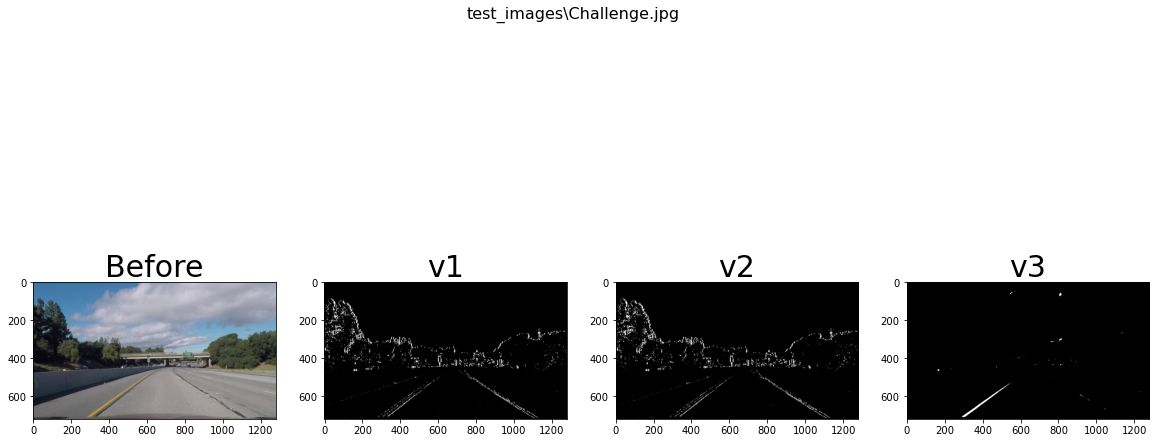

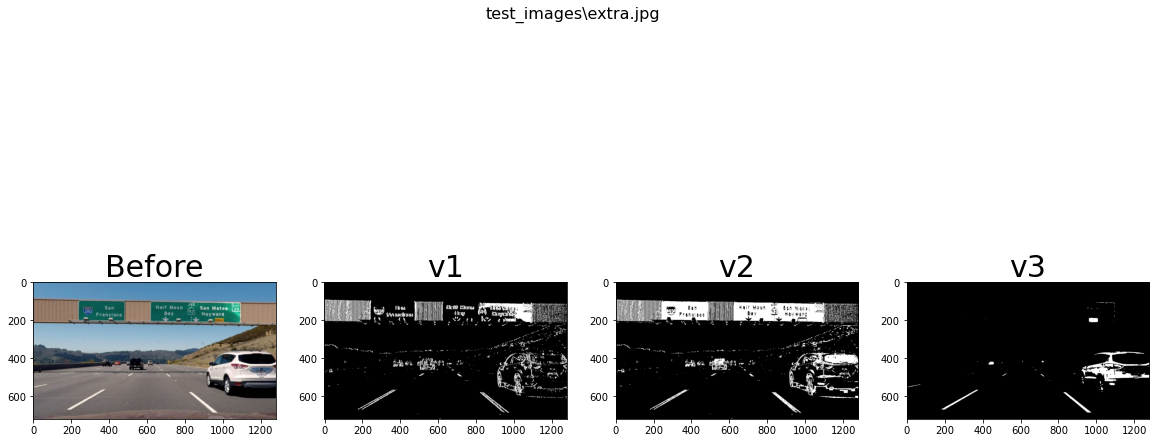

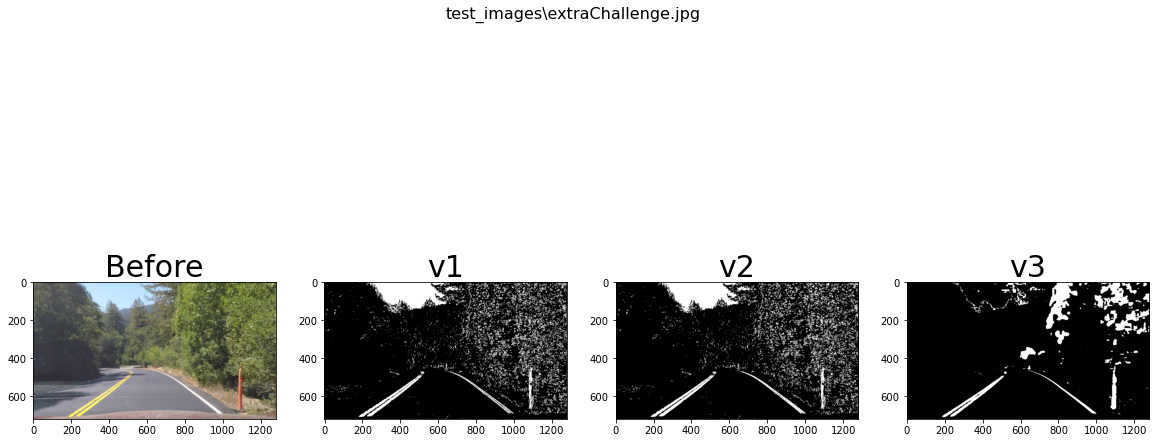

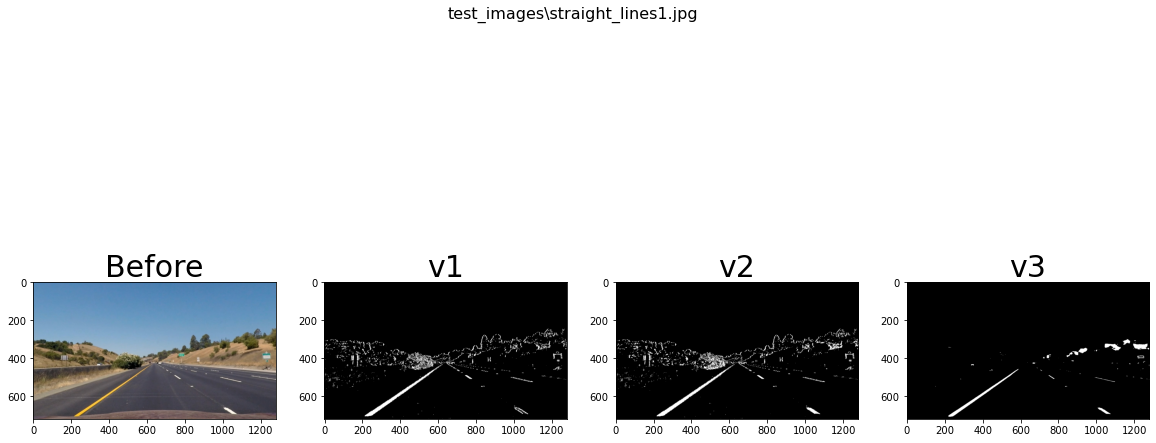

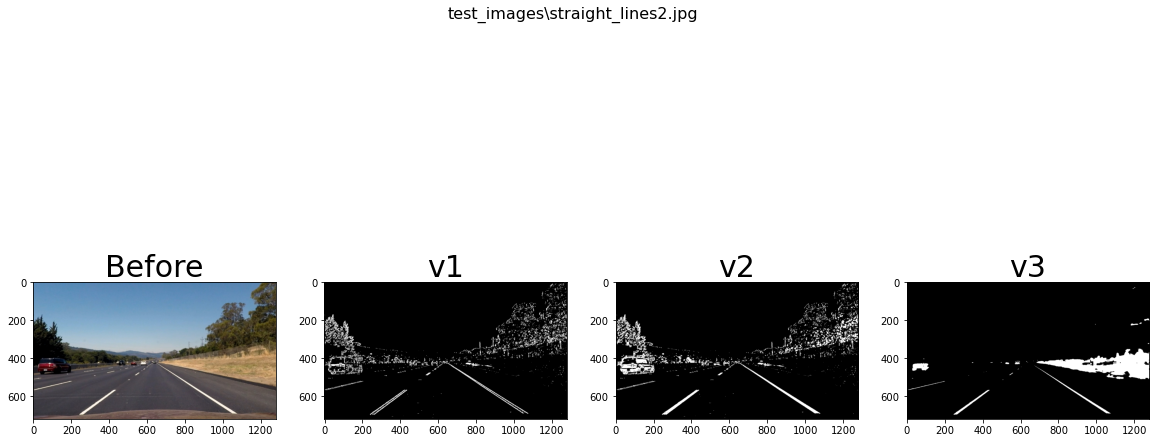

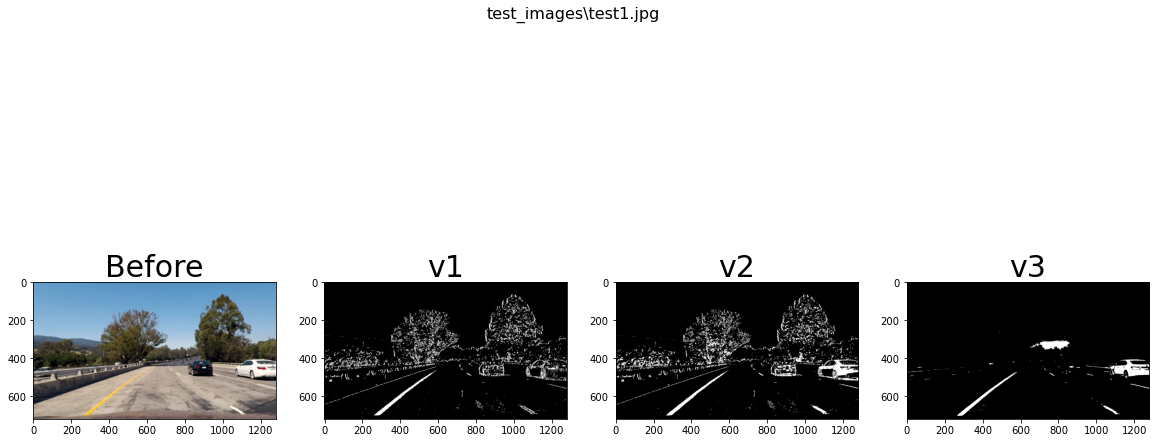

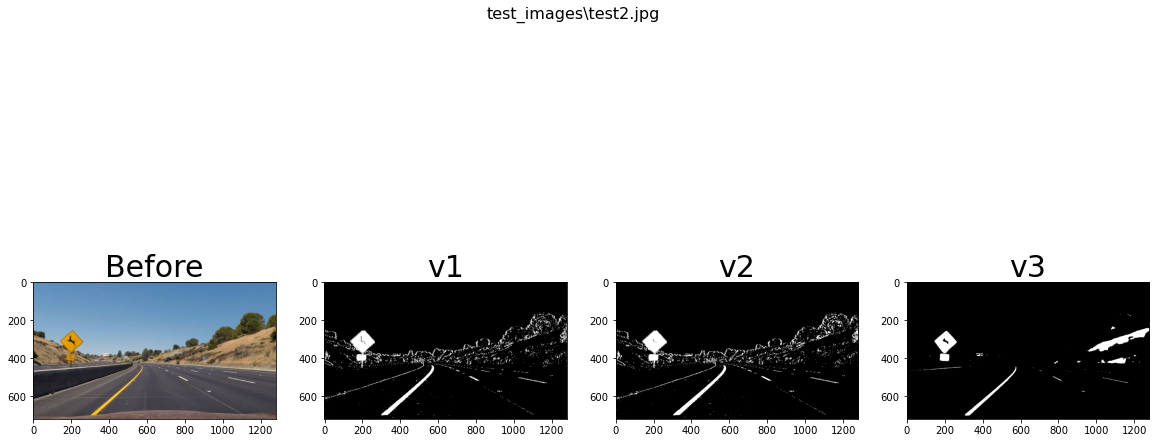

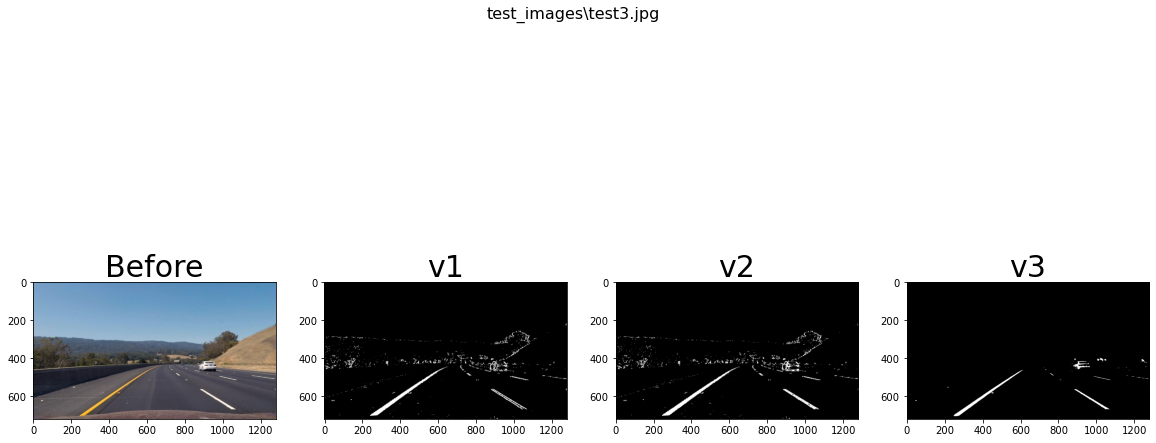

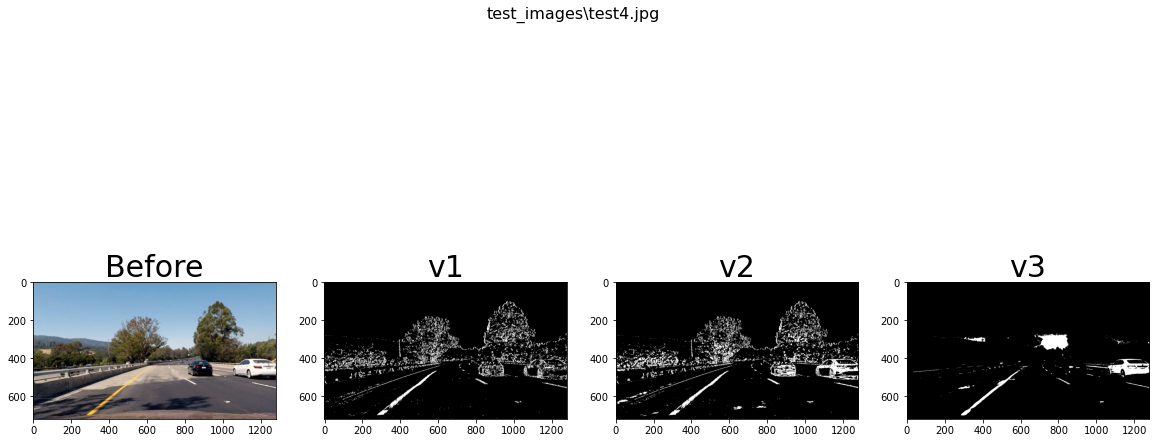

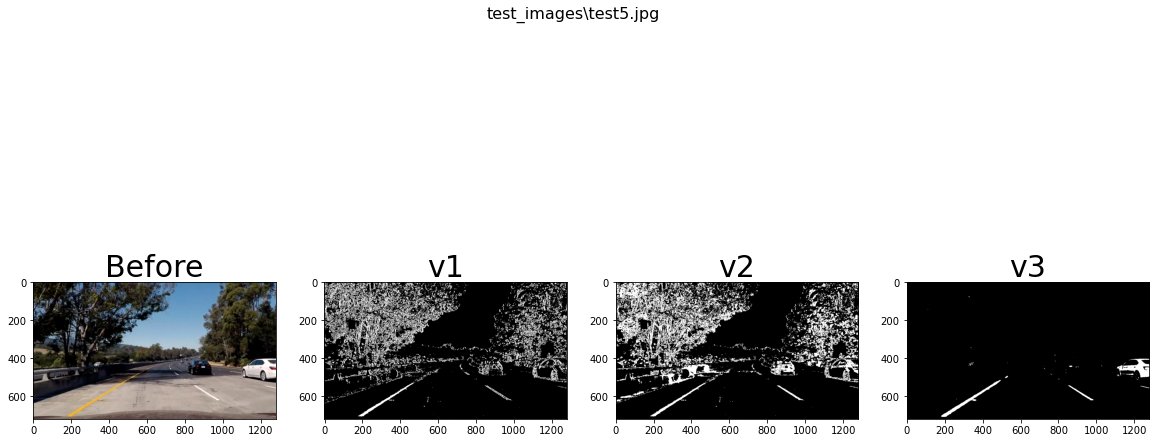

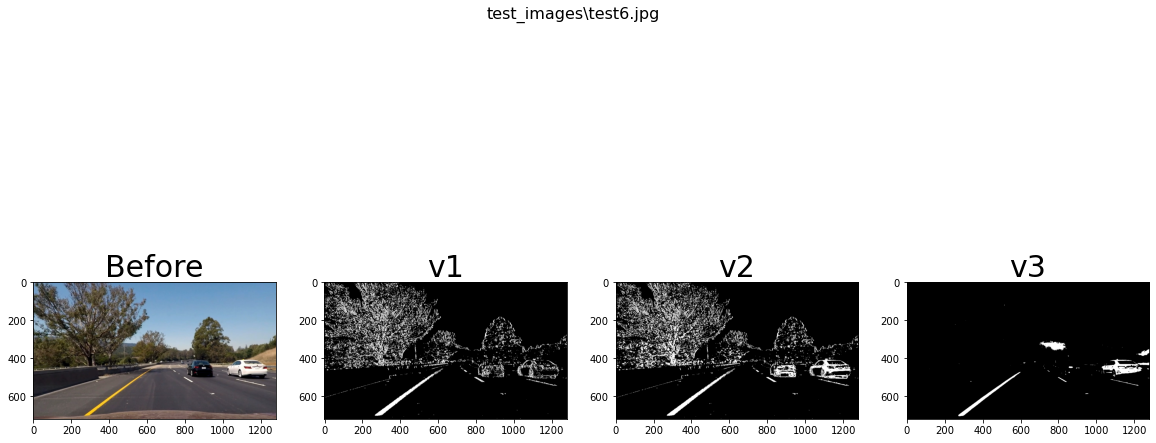

In [124]:
# Display the before and after
for fname in Test_images:
    example_distorted_test_image = cv2.imread(fname)
    example_distorted_test_image_RGB = cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB)
    example_undistorted_test_image = cv2.undistort(example_distorted_test_image_RGB,mtx,dist)    
    result1=generate_binary_image_v1(example_undistorted_test_image)
    result2=generate_binary_image_v2(example_undistorted_test_image)
    result3=generate_binary_image_v3(example_undistorted_test_image)
    
    if showimages==False:
        fig= plt.figure(figsize=(20,10))
        plt.subplot(141),plt.imshow(example_undistorted_test_image)
        plt.title('Before', fontsize=30)
        plt.subplot(142),plt.imshow(result1, cmap='gray')
        plt.title('v1', fontsize=30)
        plt.subplot(143),plt.imshow(result2, cmap='gray')
        plt.title('v2', fontsize=30)
        plt.subplot(144),plt.imshow(result3, cmap='gray')
        plt.title('v3', fontsize=30)
        fig.suptitle(fname, fontsize=16)

    if saveimages:
        mpimg.imsave("Transformed_"+fname,result, cmap='gray')



## 2.3 Perspective Transform

In [125]:
def warper(image):
    image_size = image.shape[:2]
    img_size = (image_size[1], image_size[0])  
    
    src = np.float32(
        [[259, 692],
         [608, 444],
         [672, 444],
         [1160, 692]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1047,0],
         [1047,720]])
  
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    inverse_warp_matrix = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, perspective_matrix, img_size)
    return warped, inverse_warp_matrix

#https://nikolasent.github.io/opencv/2017/05/07/Bird's-Eye-View-Transformation.html
#https://nikolasent.github.io/proj/proj1
def warper_V2(image):
    image_size = image.shape[:2]
    img_size = (1280, 223)  
    src = np.float32([[0, 673],     [1207, 673],     [0, 450], [1280, 450]])
    dst = np.float32([[569, 223], [711, 223], [0, 0], [1280, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    img = np.copy(image) # Read the test img
   # img = img[450:(450+IMAGE_H), 0:IMAGE_W] # Apply np slicing for ROI crop
    warped_img = cv2.warpPerspective(img, M,img_size) # Image warping
    #plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results
    #plt.show()
    return warped_img, Minv

In [126]:
# Display the before and after
for fname in Test_images:
    example_distorted_test_image = cv2.imread(fname)
    example_distorted_test_image_RGB = cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB)
    example_undistorted_test_image = cv2.undistort(example_distorted_test_image_RGB,mtx,dist)    
    warped, inverse_warp_matrix =warper_V2(example_undistorted_test_image) 

    if showimages:
        fig=plt.figure(figsize=(20,10))
        plt.subplot(121),plt.imshow(example_undistorted_test_image)
        plt.title('Before', fontsize=30)
        plt.subplot(122),plt.imshow(warped)
        plt.title('After', fontsize=30)
        fig.suptitle(fname, fontsize=16)

    mpimg.imsave("Warped_"+fname,warped)

## 2.4 Identify lane-line pixels and fit a polynomial

In [127]:
# Display the before and after
for fname in Test_images:
    example_distorted_test_image = cv2.imread(fname)
    example_distorted_test_image_RGB = cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB)
    example_undistorted_test_image = cv2.undistort(example_distorted_test_image_RGB,mtx,dist)
    binary = generate_binary_image(example_undistorted_test_image)
    warped, inverse_warp_matrix =warper_V2(binary) 

    if showimages:
        fig=plt.figure(figsize=(20,10))
        plt.subplot(121),plt.imshow(example_undistorted_test_image)
        plt.title('Before', fontsize=30)
        plt.subplot(122),plt.imshow(warped, cmap='gray')
        plt.title('After', fontsize=30)
        fig.suptitle(fname, fontsize=16)

    mpimg.imsave("Transformed_Warped_"+fname,warped, cmap='gray')

In [128]:
def sliding_window_lane_search(image, left_fit, right_fit):
    output_buffer = np.dstack((image, image, image))*255
    
    # Get a histogram of the bottom part of the image
    histogram = np.sum(image[np.int(image.shape[0]*1 / 2):, 569:711], axis=0)
    #plt.figure()
    #plt.plot(histogram)

    # Discover possible starting points for the left and right lines 
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])+569
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint+569

    num_windows = 9
    window_height = np.int(warped.shape[0]/num_windows)

    # x/y positions of all nonzeros in the image
    nonzero = image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Position buffers for use when moving from window to window
    # Starts at our possible starting points
    current_left_x = left_x_base
    current_right_x = right_x_base

    # Margine on each side of each window?
    margin = 10

    # Minimum pixels to recenter a window?
    recenter_minimum = 3

    # Buffers for left and right lane pixel indices
    left_lane_indices = []
    right_lane_indices = []

    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window + 1) * window_height
        win_y_high = image.shape[0] - window * window_height
        win_xleft_low = current_left_x - margin
        win_xleft_high = current_left_x + margin
        win_xright_low = current_right_x - margin
        win_xright_high = current_right_x + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(
            output_buffer,
            (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),
            (0, 255, 0),
            2
        ) 
        cv2.rectangle(
            output_buffer,
            (win_xright_low, win_y_low),
            (win_xright_high, win_y_high),
            (0, 255, 0),
            2
        ) 
        # Identify the nonzero pixels in x and y within the window
        good_left_indices = (
            (nonzero_y >= win_y_low) & 
            (nonzero_y < win_y_high) & 
            (nonzero_x >= win_xleft_low) & 
            (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_indices = (
            (nonzero_y >= win_y_low) & 
            (nonzero_y < win_y_high) & 
            (nonzero_x >= win_xright_low) & 
            (nonzero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_indices) > recenter_minimum:
            current_left_x = np.int(np.mean(nonzero_x[good_left_indices]))
        if len(good_right_indices) > recenter_minimum:        
            current_right_x = np.int(np.mean(nonzero_x[good_right_indices]))
            
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices]
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    try:
        new_left_fit = np.polyfit(left_y, left_x, 2)
    except TypeError:
        new_left_fit = left_fit
    try:
        new_right_fit = np.polyfit(right_y, right_x, 2)
    except TypeError:
        new_right_fit = right_fit
    
    # Do visualization

    output_buffer[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
    output_buffer[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]
    
    return new_left_fit, new_right_fit, output_buffer, right_x, right_y, left_x, left_y


def preexisting_lane_search(image, left_fit, right_fit):
    output_buffer = np.dstack((image, image, image))*255
    nonzero = image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 10
    left_lane_indices = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) & (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin))) 
    right_lane_indices = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) & (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
    except TypeError:
        left_fit, right_fit, output_buffer, right_x, right_y, left_x, left_y = sliding_window_lane_search(image, left_fit, right_fit)

    output_buffer[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
    output_buffer[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]
    return left_fit, right_fit,output_buffer, right_x, right_y, left_x, left_y

(223.0, 0.0)

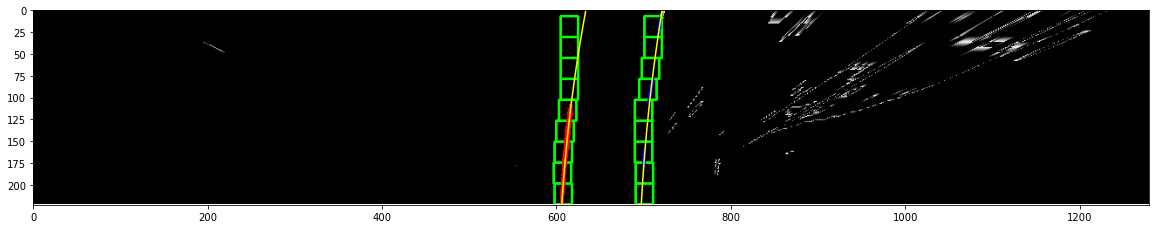

In [129]:
left_fit, right_fit, out_image, _, _, _, _ = sliding_window_lane_search(warped, None, None)

# Generate x and y values for plotting
ploty = np.linspace(0, out_image.shape[0]-1, out_image.shape[0] )
left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.figure(figsize=(20, 20))
plt.imshow(out_image)
plt.plot(left_fit_x, ploty, color='yellow')
plt.plot(right_fit_x, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(223, 0)


## 5. Computing Radius of Curvature

In [130]:
meters_per_pixel_y = 3.048/30 #Dashed line length (10 ft in m) is ~30 px on image
meters_per_pixel_x = 3.7/100 # Lane width (12 ft in m) is ~100 px on image 

def radius_of_curvature(y_value, right_x, left_x, right_y, left_y):
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y, left_x, 2)
    right_fit_cr = np.polyfit(right_y, right_x, 2)
    al, bl, cl = left_fit_cr
    ar, br, cr = left_fit_cr
    left = (1 + (((2 * al * y_value * meters_per_pixel_y) + bl) ** 2) ** (1.5))/ np.absolute(2 * al)
    right = (1 + (((2 * ar * y_value * meters_per_pixel_y) + br) ** 2) ** (1.5))/ np.absolute(2 * ar)
    return left, right

def distance_from_center(left_fit, right_fit, y_value, x_size):
    left_fit_x = left_fit[0]*y_value**2 + left_fit[1]*y_value + left_fit[2]
    right_fit_x = right_fit[0]*y_value**2 + right_fit[1]*y_value + right_fit[2]
    
    center_of_car = x_size / 2
    center_of_lane = (left_fit_x + right_fit_x) / 2
    return (center_of_lane - center_of_car) * meters_per_pixel_x

## 6. Drawing Detected Lanes

In [131]:
def draw_lane_lines(warped_image, left_fit, right_fit, inverse_warp_matrix, destination_image):
    # Image for drawing
    destination_image = np.copy(destination_image)
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    ploty = np.linspace(0, warp_zero.shape[0]-1, warp_zero.shape[0] )
    left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Convert x & y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_warp_matrix, ( 1280,720)) 
    # Combine the result with the original image
    result = cv2.addWeighted(destination_image, 1, newwarp, 0.3, 0)
    
    return result
    
import datetime
    
def draw_radius_of_curvature(image, radius, last_draw):
    
    if (datetime.datetime.now() - last_draw).total_seconds() > 1:
        last_draw = datetime.datetime.now()
        radius = min_radius
    
    cv2.putText(
        image,
        "Radius of Curvature: {radius} m".format(radius=round(radius, 3)),
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.1,
        (255, 255, 255),
        2,
    )
    return last_draw

def draw_center_offset(left_fit, right_fit, image):
    y_value = image.shape[0]
    distance = distance_from_center(left_fit, right_fit, y_value, image.shape[1])
    
    cv2.putText(
        image,
        "Offset from center of lane: {distance} m".format(distance=round(distance, 3)),
        (10, 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.1,
        (255, 255, 255),
        2,
    )
    

Text(0.5, 0.98, 'test_images\\test6.jpg')

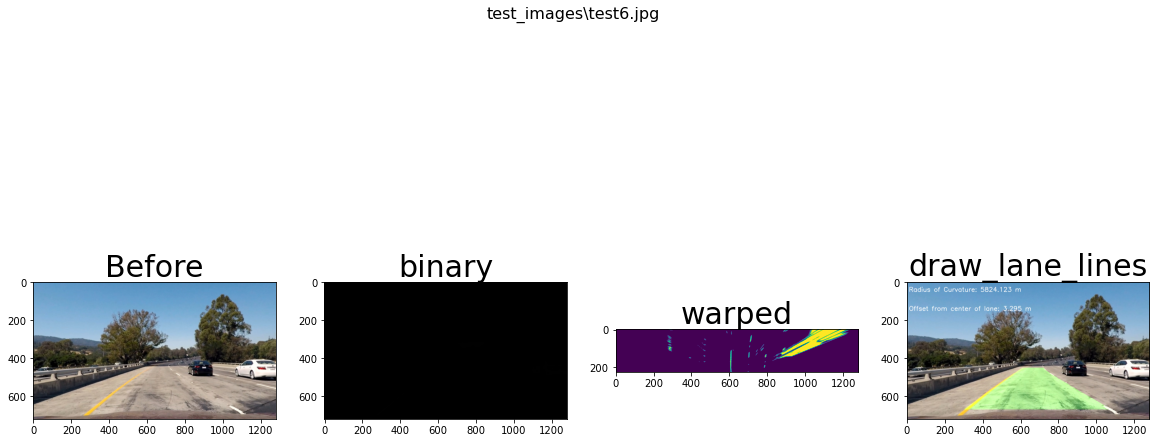

In [132]:
example_distorted_test_image = cv2.imread('test_images/test1.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    mtx,
    dist
)
example_undistorted_test_image = cv2.cvtColor(example_undistorted_test_image, cv2.COLOR_BGR2RGB)

binary = generate_binary_image(example_undistorted_test_image)

warped, inverse_warp_matrix = warper_V2(binary)

left_fit, right_fit, _, right_x, right_y, left_x, left_y = sliding_window_lane_search(warped, None, None)

new_image = draw_lane_lines(warped, left_fit, right_fit, inverse_warp_matrix, example_undistorted_test_image)

last_draw = datetime.datetime.now()
y_value = new_image.shape[0]
radius_left, radius_right = radius_of_curvature(y_value, right_x, left_x, right_y, left_y)

min_radius = min([radius_left, radius_right])

last_draw = draw_radius_of_curvature(new_image, min_radius, last_draw)
draw_center_offset(left_fit, right_fit, new_image)

binary2=cv2.cvtColor(binary*255, cv2.COLOR_GRAY2RGB)
fig=plt.figure(figsize=(20,10))
plt.subplot(141),plt.imshow(example_undistorted_test_image)
plt.title('Before', fontsize=30)
plt.subplot(142),plt.imshow(binary2)
plt.title('binary', fontsize=30)
plt.subplot(143),plt.imshow(warped )
plt.title('warped', fontsize=30)
plt.subplot(144),plt.imshow(new_image)
plt.title('draw_lane_lines', fontsize=30)
fig.suptitle(fname, fontsize=16)

# III. Pipelining for Video

In [133]:
global last_5_radius
last_5_radius = []
def lane_detector_pipeline(image, left, right):
    image = np.copy(image)
    undistorted_image = cv2.undistort(
        image,
        mtx,
        dist
    )
    binary = generate_binary_image(undistorted_image)
    warped, inverse_warp_matrix = warper_V2(binary)
    if left is None and right is None:
        left_fit, right_fit, out, right_x, right_y, left_x, left_y = sliding_window_lane_search(warped, left, right)
    else:
        left_fit, right_fit, out, right_x, right_y, left_x, left_y = preexisting_lane_search(warped, left, right)
    drawn = draw_lane_lines(
        warped,
        left_fit,
        right_fit,
        inverse_warp_matrix,
        undistorted_image
    )
    last_draw = datetime.datetime.now()
    y_value = new_image.shape[0]
    min_radius = min(radius_of_curvature(y_value, right_x, left_x, right_y, left_y))


    if len(last_5_radius) == 5:
        last_5_radius.pop()
    last_5_radius.insert(0, min_radius)

    last_draw = draw_radius_of_curvature(drawn, sum(last_5_radius) / len(last_5_radius), last_draw)
    draw_center_offset(left_fit, right_fit, drawn)

    return drawn, left_fit, right_fit


In [134]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [135]:
class ImageProcessor:
    per_image_fit_left = None
    per_image_fit_right = None
    def process_image(self, image):
        drawn, self.per_image_fit_left, self.per_image_fit_right = lane_detector_pipeline(image, self.per_image_fit_left, self.per_image_fit_right)
        return drawn

processor = ImageProcessor()
    
output = 'Project_Output/challenge_output_v3.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,10)
project_clip = clip1.fl_image(processor.process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output, audio=False)

t:   0%|          | 3/1260 [00:00<01:04, 19.53it/s, now=None]Moviepy - Building video Project_Output/challenge_output_v3.mp4.
Moviepy - Writing video Project_Output/challenge_output_v3.mp4

t: 100%|█████████▉| 1259/1260 [01:20<00:00, 16.20it/s, now=None]Moviepy - Done !
Moviepy - video ready Project_Output/challenge_output_v3.mp4
Wall time: 1min 21s
